In [330]:
import numpy as np
import matplotlib.pyplot as plt

In [331]:
# Population count. It is constant over the experience.
N: int = 100
# The transmission parameter.
beta: float = 0.02
# The recovery rate. Used in the SIS model (the last one).
gamma: float = 0.006
# Initial infected people. Must be <= N.
I0: int = 3
# Number of days to simulate in the experience.
t_max: int = 365 * 2 # one year

In [332]:
# Sanity checks.
assert(N > 0)
assert(beta >= 0)
assert(gamma >= 0)
assert(I0 <= N and I0 >= 0)
assert(t_max > 0)

In [333]:
sigma: float = beta / gamma
print("Sigma :", sigma)

Sigma : 3.3333333333333335


In [334]:
SHOW_S_CURVE = False

def show_plot(I, title = "", asymptote: bool = False):
    plt.xlabel("Time (in days)")
    plt.ylabel("Infected people")
    plt.plot(range(t_max), I, label="Infected people")
    if SHOW_S_CURVE:
        plt.plot(range(t_max), N - I, label="Healthy people")
    plt.title(title)

    if asymptote:
        max: float = I[-1]
        plt.axhline(max, ls='--')

    plt.legend()
    plt.show()

## First model

In [342]:
I = np.zeros(t_max)
I[0] = I0

for t in range(1, t_max):
    # We clamp the infected count over N. We can not have more infected 
    # people than total alive people.
    # This just avoid the model to explode, and show a better graph.
    # But it is not exactly the same as described in the paper.
    I[t] = min(N, (1 + beta) * I[t-1])

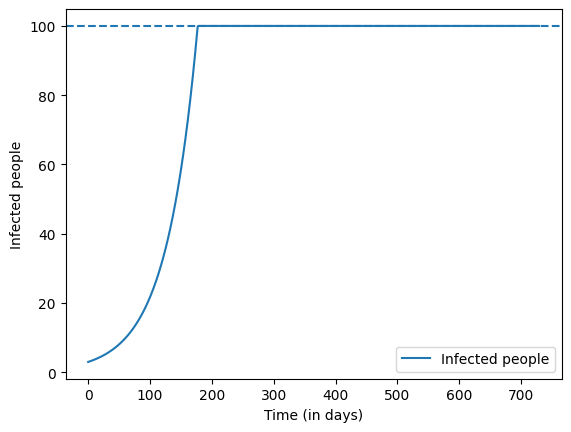

In [336]:
show_plot(I, asymptote=True)

## Second model

In [337]:
I = np.zeros(t_max)
I[0] = I0

# In the two following models, we do not store explictly the S curve.
# It is represented implictly as N - I. This avoid storing excessive useless data.

coef: float = beta / N # compute the division once to avoid useless repetition
for t in range(1, t_max):
    I[t] = I[t-1] + coef * I[t-1] * (N - I[t-1])

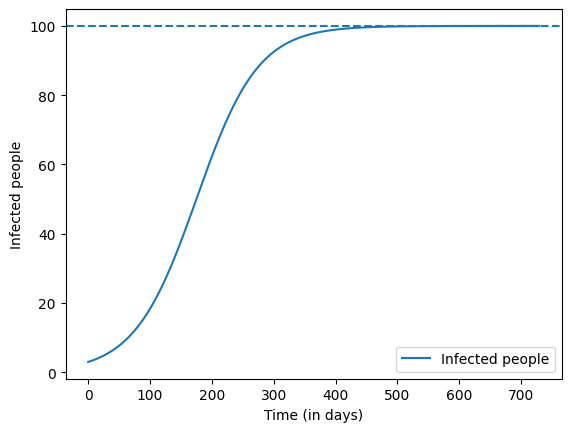

In [338]:
show_plot(I, asymptote=True)

## Last : the SIS model

In [339]:
def sis_model(beta: float, gamma: float, N: int = N, I0: int = I0, t_max: int = t_max):
    I = np.zeros(t_max)
    I[0] = I0

    coef: float = beta / N # compute the division once
    for t in range(1, t_max):
        I[t] = (1 + coef * (N - I[t-1]) - gamma) * I[t-1]

    return I

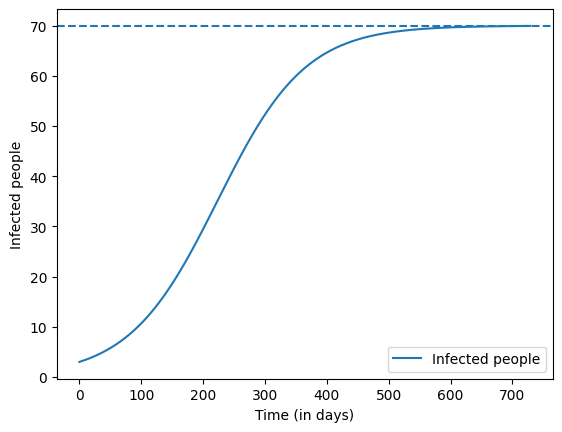

In [340]:
I = sis_model(beta, gamma)
show_plot(I, asymptote=True)

### Different $\sigma$

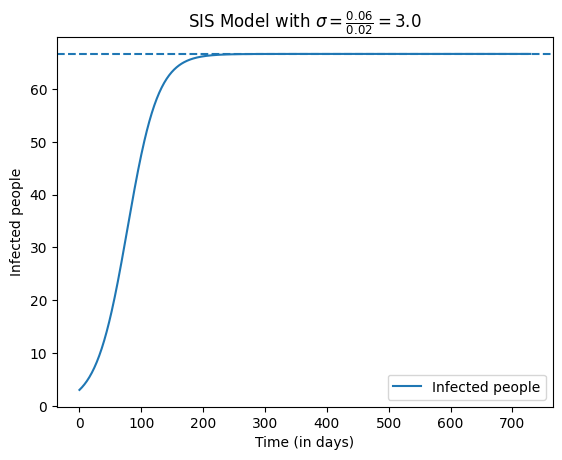

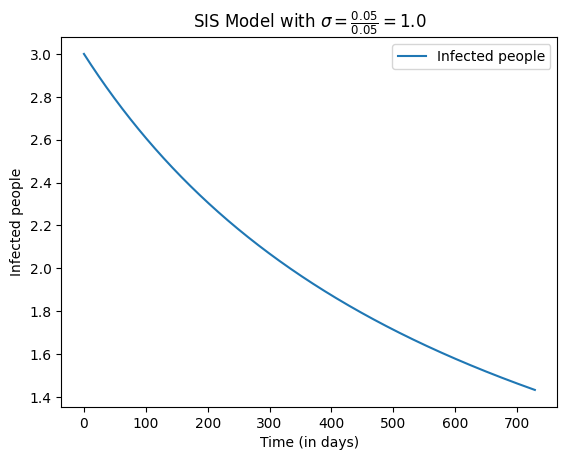

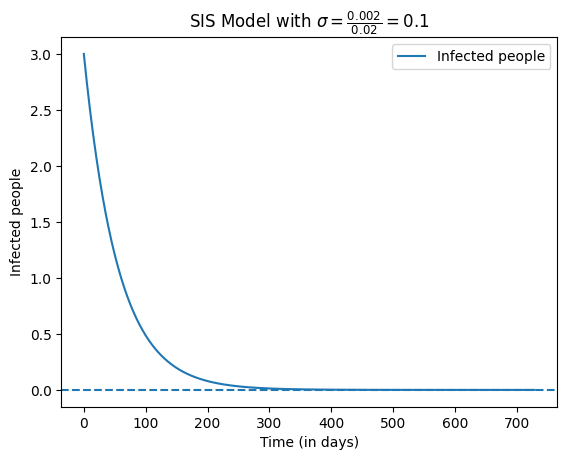

In [341]:
def show_sigma_influence(beta: float, gamma: float, asymptote: bool = False) -> None:
    show_plot(sis_model(beta, gamma), "SIS Model with $\\sigma = \\frac{{ {} }}{{ {} }} = {}$".format(beta, gamma, beta / gamma), asymptote=asymptote)

show_sigma_influence(0.06, 0.02, asymptote=True)
show_sigma_influence(0.05, 0.05)
show_sigma_influence(0.002, 0.02, asymptote=True)